<h1> Welcome to the Empirical Proof that Explanation Types are Orthogonal </h1>

<h3> lets begin by fitting a NN to a gaussian distribution centered at 0,0 with a variance of 1! </h3>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Define the neural network architecture
class GaussianEstimatorNN(nn.Module):
    def __init__(self):
        super(GaussianEstimatorNN, self).__init__()
        self.input_layer = nn.Linear(2, 32)  # Input layer with 2 inputs (x, y)
        self.hidden_layer = nn.Linear(32, 32)  # Hidden layer with 32 units
        self.output_layer = nn.Linear(32, 1)  # Output layer with 1 output (PDF value)
        self.relu = nn.LeakyReLU()

    def forward(self, x):
        x = self.relu(self.input_layer(x))
        x = self.relu(self.hidden_layer(x))
        return self.output_layer(x)

# Function to generate training samples
def generate_samples(n_samples):
    x = torch.empty(n_samples, 2).uniform_(-5, 5)  # Uniform samples in [-5, 5] for x and y
    mean = torch.tensor([0.0, 0.0])
    cov = torch.tensor([[1.0, 0.0], [0.0, 1.0]])  # Corrected covariance matrix to be positive definite
    inv_cov = torch.inverse(cov)
    targets = torch.empty(n_samples, 1)

    for i in range(n_samples):
        diff = x[i] - mean
        exponent = -0.5 * torch.dot(diff, torch.mv(inv_cov, diff))
        pdf_value = (1 / (2 * math.pi * torch.det(cov).sqrt())) * torch.exp(exponent)
        targets[i] = pdf_value

    return x, targets

# Training parameters
n_samples = 1000
batch_size = 64
epochs = 50
learning_rate = 0.001

# Create the neural network, loss function, and optimizer
model = GaussianEstimatorNN().cuda() if torch.cuda.is_available() else GaussianEstimatorNN()
criterion = nn.MSELoss()  # Mean Squared Error loss
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(epochs):
    model.train()

    # Generate the dataset
    inputs, targets = generate_samples(n_samples)
    if torch.cuda.is_available():
        inputs, targets = inputs.cuda(), targets.cuda()

    # Split into batches
    for i in range(0, n_samples, batch_size):
        input_batch = inputs[i:i + batch_size]
        target_batch = targets[i:i + batch_size]

        # Forward pass
        output = model(input_batch)
        loss = criterion(output, target_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

print("Training complete!")


Epoch [10/50], Loss: 0.0006
Epoch [20/50], Loss: 0.0003
Epoch [30/50], Loss: 0.0002
Epoch [40/50], Loss: 0.0001
Epoch [50/50], Loss: 0.0000
Training complete!


<h3> Lets see what it looks like! </h3>

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


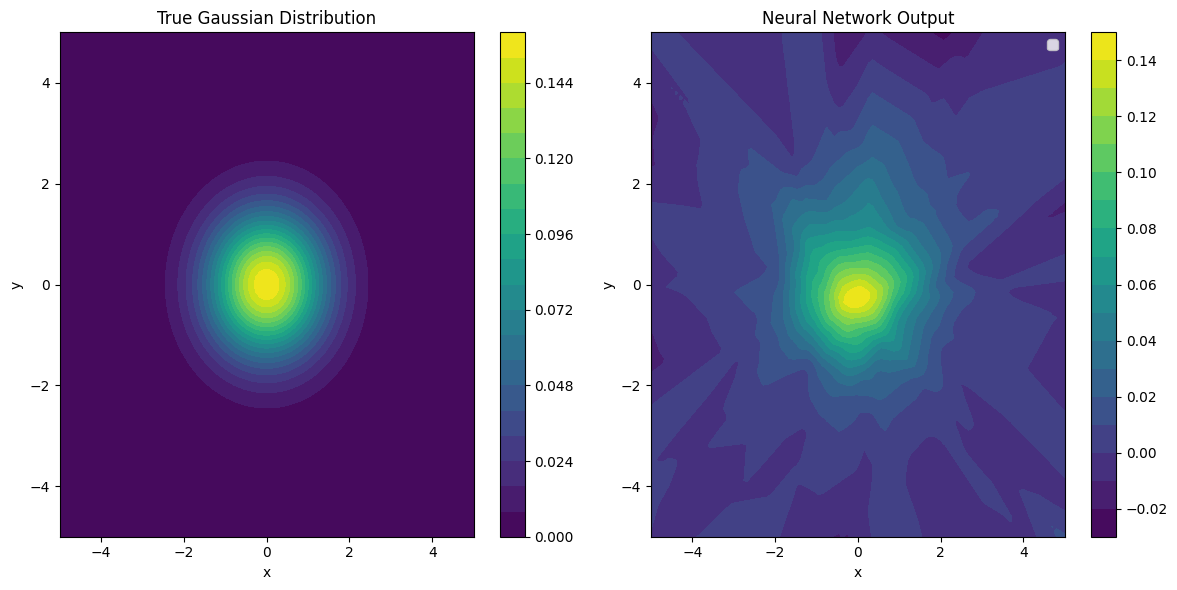

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [2]:
def gaussian_pdf(x, y, mean, cov):
    xy = np.stack([x, y], axis=-1)
    diff = xy - mean
    inv_cov = np.linalg.inv(cov)
    exponent = -0.5 * np.einsum('...i,ij,...j->...', diff, inv_cov, diff)
    pdf_value = (1 / (2 * np.pi * np.linalg.det(cov) ** 0.5)) * np.exp(exponent)
    return pdf_value
mean = np.array([0.0, 0.0])
cov = np.array([[1.0, 0.0], [0.0, 1.0]])

# Generate grid for the contour plot
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)

# Generate the true Gaussian distribution contour plot
Z = gaussian_pdf(X, Y, mean, cov)

plt.figure(figsize=(12, 6))

# Plot the true Gaussian distribution
plt.subplot(1, 2, 1)
plt.contourf(X, Y, Z, levels=20, cmap='viridis')
plt.colorbar()
plt.title('True Gaussian Distribution')
plt.xlabel('x')
plt.ylabel('y')
model.eval()
X_flat = X.flatten()
Y_flat = Y.flatten()
grid_points = torch.tensor(np.stack([X_flat, Y_flat], axis=-1), dtype=torch.float32)

if torch.cuda.is_available():
    grid_points = grid_points.cuda()

with torch.no_grad():
    Z_nn = model(grid_points).cpu().numpy()

Z_nn = Z_nn.reshape(X.shape)

plt.subplot(1, 2, 2)
plt.contourf(X, Y, Z_nn, levels=20, cmap='viridis')
plt.colorbar()
plt.title('Neural Network Output')
plt.xlabel('x')
plt.ylabel('y')
# Plot a point of interest (POI) as a red dot

plt.legend()
plt.tight_layout()
plt.show()
plt.tight_layout()
plt.show()
plt.tight_layout()
plt.show()

<h3> Wow that's patchy! but hey they tried their best! </h3>

<h3> Let's get some <i>Feature Importances</i> </h3>

In [3]:
from FeatureImportance.methods.FiniteDifferences import FiniteDifferences
from FeatureImportance.methods.LRP import TwoDWeights_LRPModel
from FeatureImportance.methods.LIME import LIME
from FeatureImportance.methods.SHAP import SHAP

lime = LIME(model, 1)
shap = SHAP(model)
fd = FiniteDifferences(model)
lrp = TwoDWeights_LRPModel(model)

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [4]:
def get_gradient(model, point):
    """
    Computes the gradient of the model output with respect to the input point.
    
    Args:
        model: a PyTorch model
        point: a 1D torch tensor of shape (input_dim,) or (1, input_dim)

    Returns:
        gradient: a 1D torch tensor of shape (input_dim,)
    """
    point = torch.tensor(point, dtype=torch.float64)
    model.eval()
    point = point.clone().detach().requires_grad_(True)

    output = model(point)
    if output.ndim > 1:
        output = output.squeeze()

    # If scalar output
    assert output.numel() == 1, "Output must be scalar for gradient calculation"
    output.backward()

    gradient = point.grad.detach().clone()
    return gradient

Specify our points of interest

In [5]:
POEs = np.array([[4.0, -4.0],[1.0,1.0],[0.0,0.0],[2.0,2.0],[-1.,-1],[1.,-1.],[-1.,1.],[3.,-3.2]])
#_,lime_exp = lime.get_fi(POEs)
#lime_exp = np.reshape(lime_exp,(7,2))
_,shap_exp = shap.get_fi(POEs)
_,fd_exp = fd.get_fi(POEs, h = 1e-5)
fd_exp = np.reshape(fd_exp*5, (8,2))
lrp_exp = []
#fd_exp = []
POEs_torch = torch.tensor(POEs, dtype = torch.float32)
for i in POEs_torch:
    lrp = TwoDWeights_LRPModel(model)
    _, lrp_expt = lrp.get_FI(i)
    lrp_exp.append(lrp_expt[0].numpy())
    #fd_exp.append(get_gradient(model, i).numpy())
lrp_exp = np.stack(lrp_exp)
#fd_exp = np.stack(fd_exp)


In [6]:
fd_exp

array([[-0.01955777, -0.06984919],
       [-0.13038516, -0.29616058],
       [ 0.11175871, -0.3427267 ],
       [-0.09033829, -0.01955777],
       [ 0.2924353 ,  0.29057264],
       [-0.24493784,  0.03818423],
       [ 0.05308539, -0.18905848],
       [ 0.09313226,  0.10617077]], dtype=float32)

In [7]:
lrp_exp

array([[ 0.00066362, -0.00178404],
       [ 0.01975859,  0.02774775],
       [ 0.06859019,  0.06859019],
       [-0.00392447,  0.01726167],
       [ 0.0733243 , -0.01623217],
       [ 0.0252863 ,  0.02905643],
       [ 0.07000685, -0.01171144],
       [-0.00026109, -0.00058467]], dtype=float32)

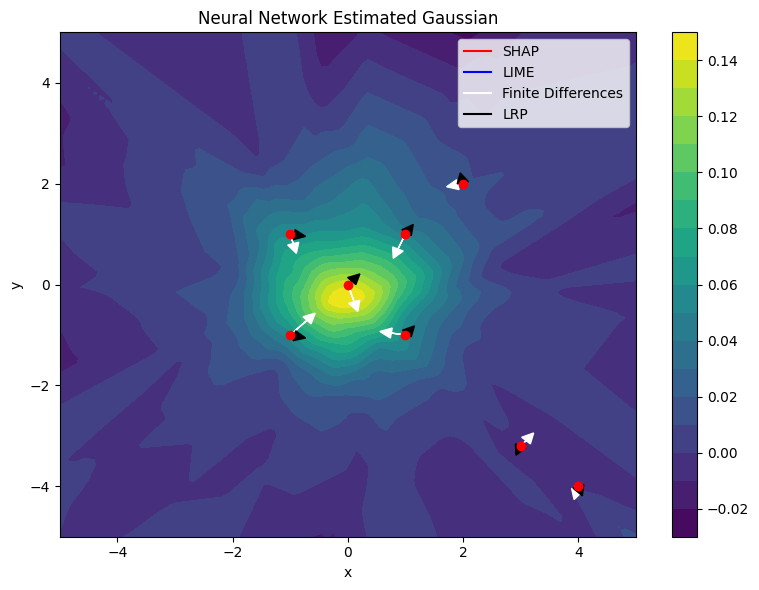

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# --- Assumes model is defined and trained ---
model.eval()

# Define grid
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)
X_flat = X.flatten()
Y_flat = Y.flatten()
grid_points = torch.tensor(np.stack([X_flat, Y_flat], axis=-1), dtype=torch.float32)

if torch.cuda.is_available():
    model = model.cuda()
    grid_points = grid_points.cuda()

# Get model predictions over the grid
with torch.no_grad():
    Z_nn = model(grid_points).cpu().numpy().reshape(X.shape)

# --- Plotting Section ---
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, Z_nn, levels=20, cmap='viridis')
plt.colorbar()
plt.title('Neural Network Estimated Gaussian')
plt.xlabel('x')
plt.ylabel('y')

# === POEs and Explanation Arrows ===
# POEs: np.array of shape (n_points, 2)
# Each *_exp: np.array of shape (n_points, 2)

# Assume these are defined somewhere earlier
# POEs = np.array([[x1, y1], [x2, y2], ...])
# shap_exp = np.array([[dx1, dy1], ...])
# lime_exp = ...
# fd_exp = ...
# lrp_exp = ...

colors = {
    "SHAP": 'red',
    "LIME": 'blue',
    "Finite Differences": 'white',
    "LRP": 'black'
}

# Plot arrows from each POE
for i, (x, y) in enumerate(POEs):
    plt.plot(x, y, 'ro')  # Red dot for POE
   
   
    # plt.arrow(x, y, shap_exp[i, 0], shap_exp[i, 1], color=colors["SHAP"], head_width=0.2, head_length=0.2)
    # plt.arrow(x, y, lime_exp[i, 0], lime_exp[i, 1], color=colors["LIME"], head_width=0.2, head_length=0.2)
    plt.arrow(x, y, fd_exp[i, 0], fd_exp[i, 1], color=colors["Finite Differences"], head_width=0.2, head_length=0.2)
    plt.arrow(x, y, lrp_exp[i, 0], lrp_exp[i, 1], color=colors["LRP"], head_width=0.2, head_length=0.2)

# Add legend (invisible lines just to show labels)
for label, color in colors.items():
    plt.plot([], [], color=color, label=label)

plt.legend()
plt.tight_layout()
plt.show()

In [9]:
def get_gradient(model, point):
    x = torch.tensor([point], requires_grad=True)  # Shape: [batch_size, input_dim]

    # Forward pass
    output = model(x)  # Shape: [batch_size, output_dim]

    # If you want gradient of **single scalar output**, sum or index the output
    #output_scalar = output.sum()

    # Compute gradients
    output.backward()
    
    # Access gradient of output w.r.t input
    print(x.grad)  # This is ∂output/∂x

In [10]:
get_gradient(model, torch.tensor([0,0], dtype=torch.float32))

ValueError: only one element tensors can be converted to Python scalars

In [11]:
get_gradient(model, [0.,0.])

tensor([[ 0.0218, -0.0680]])


In [12]:
grads = torch.autograd.grad(outputs=output, inputs=torch.tensor([0.,0.,], dtype=torch.float32, requires_grad=True), grad_outputs=torch.ones_like(output), create_graph=True)[0]

RuntimeError: One of the differentiated Tensors appears to not have been used in the graph. Set allow_unused=True if this is the desired behavior.

In [13]:
grid_size = 50
x_vals = np.linspace(-5, 5, grid_size)
y_vals = np.linspace(-5, 5, grid_size)
X, Y = np.meshgrid(x_vals, y_vals)

cosine_map = np.zeros_like(X)

model.eval()



GaussianEstimatorNN(
  (input_layer): Linear(in_features=2, out_features=32, bias=True)
  (hidden_layer): Linear(in_features=32, out_features=32, bias=True)
  (output_layer): Linear(in_features=32, out_features=1, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
)

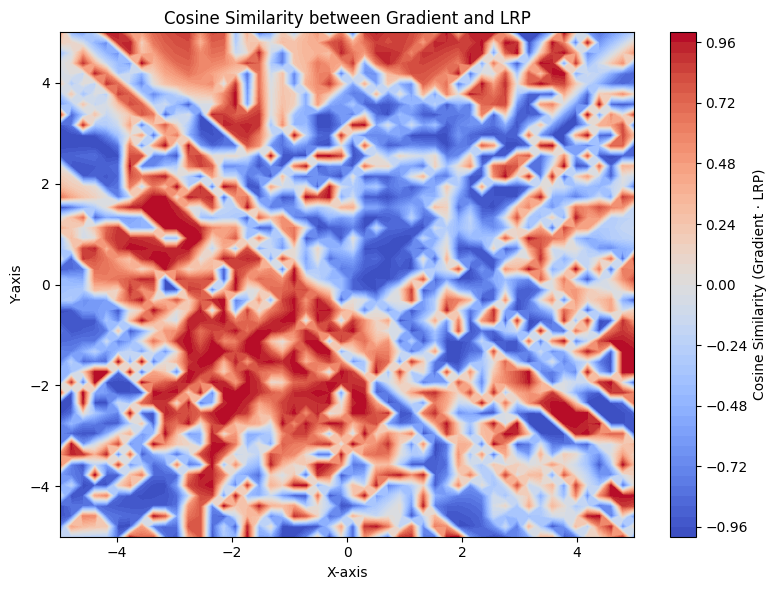

In [26]:
def cosine_sim_np(a, b, eps=1e-8):
    return a.dot(b)/(np.linalg.norm(a) * np.linalg.norm(b) + eps)
def get_gradient_scaled(model, input_tensor):
    input_tensor = input_tensor.clone().detach().float().requires_grad_(True)
    output = model(input_tensor.unsqueeze(0))
    output.backward()
    return input_tensor.grad.clone().detach().numpy() * input_tensor.grad.clone().detach().numpy()

def get_gradient(model, input_tensor):
    input_tensor = input_tensor.clone().detach().float().requires_grad_(True)
    output = model(input_tensor.unsqueeze(0))
    output.backward()
    return input_tensor.grad.clone().detach().numpy()

def smooth_grad(model, input_tensor, n_samples=50, noise_std=2., multiply_by_input=False):
    """
    Computes SmoothGrad explanation by averaging noisy gradients.
    
    Args:
        model: PyTorch model (should be in eval mode)
        input_tensor: 1D torch.Tensor of shape [input_dim]
        n_samples: number of noisy samples to draw
        noise_std: standard deviation of Gaussian noise to add
        multiply_by_input: if True, returns gradient * input (Gradient × Input)

    Returns:
        smooth_grad: torch.Tensor of shape [input_dim]
    """
    model.eval()
    grads = []

    for _ in range(n_samples):
        # Add noise to input
        noisy_input = input_tensor.clone().detach() + torch.randn_like(input_tensor) * noise_std
        noisy_input.requires_grad_(True)

        # Forward and backward
        output = model(noisy_input.unsqueeze(0))  # batch dim
        output.backward()

        grad = noisy_input.grad.clone().detach()

        if multiply_by_input:
            grad = grad * noisy_input.detach()

        grads.append(grad)

    # Average all gradients
    return torch.stack(grads).mean(dim=0)

# def grad_cam_ish(model, point):
#     activations = {}
#     gradients = {}
#     def forward_hook(name):
#         def hook(module, input, output):
#             activations[name] = output.detach()
#         return hook

#     # Hook to capture gradients w.r.t. outputs
#     def backward_hook(name):
#         def hook(module, grad_input, grad_output):
#             gradients[name] = grad_output[0].detach()
#         return hook

#     # Register hooks for each layer
#     for name, module in model.named_modules():
#         if isinstance(module, nn.Linear):
#             module.register_forward_hook(forward_hook(name))
#             module.register_backward_hook(backward_hook(name))

#     # === Sample input ===
#     input_point = torch.tensor(point, requires_grad=True, dtype=torch.float32)

#     # Forward pass
#     output = model(input_point)

#     # Backward pass (ensure scalar output)
#     output.backward()

#     # Mean gradient for each neuron (shape: [32])
#     weights = gradients['input_layer'].mean(dim=0)  # like alpha_k

#     # Weighted sum of activations (shape: [1, 32])
#     cam = (weights * activations['input_layer'].squeeze()).cpu().numpy()

#     # Optional: ReLU to zero out negatives
#     cam = np.maximum(cam, 0)

#     input_contrib = cam @ model.input_layer.weight.detach().numpy()
#     return input_contrib

def integrated_gradients(model, input_tensor, baseline=None, steps=50):
    """
    Compute Integrated Gradients for a single input.
    Args:
        model: PyTorch model
        input_tensor: 1D torch.Tensor, input point
        baseline: baseline input (same shape), default zero
        steps: number of interpolation steps

    Returns:
        IG attribution vector
    """
    model.eval()
    if baseline is None:
        baseline = torch.zeros_like(input_tensor)

    scaled_inputs = [
        baseline + (float(i) / steps) * (input_tensor - baseline)
        for i in range(1, steps + 1)
    ]

    grads = []
    for x in scaled_inputs:
        x = x.clone().detach().requires_grad_(True)
        output = model(x.unsqueeze(0))
        output.backward()
        grads.append(x.grad.detach())

    avg_grad = torch.stack(grads).mean(dim=0)
    ig = (input_tensor - baseline) * avg_grad
    return ig

for i in range(grid_size):
    for j in range(grid_size):
        point = np.array([X[i, j], Y[i, j]])

        
        #############NORMAL LRP
        lrp = TwoDWeights_LRPModel(model)
        lrp_expt = lrp.get_FI(torch.tensor(point, dtype = torch.float32))[1][0].numpy() 
        #lrp_expt = lrp_expt/np.linalg.norm(lrp_expt) * point


        #GRAD FROM DF
        # lrp_expt = fd.get_fi(np.array([[X[i, j], Y[i, j]]]), h=1e-5)[1][0][0]
        
        #############SHAP AS LRP
        #lrp_expt = shap.get_fi(np.array([[X[i, j], Y[i, j]]]))[1][0]
        
        ##############LIME AS LRP
        #lrp_expt = lime.get_fi(np.array([[X[i, j], Y[i, j]]]))[1][0][0]

        #GRAD_CAM_ISH
        #lrp_expt = grad_cam_ish(model, [[X[i, j], Y[i, j]]])
        #grad = get_gradient(model, torch.tensor([X[i, j], Y[i, j]], dtype=torch.float32)).numpy()
        
        #normalGRAD
        grad = get_gradient(model, torch.tensor(point, dtype = torch.float32))
        #THIS ONE HAS A BETTER DISTRIBUTION
        #grad = get_gradient_scaled(model, torch.tensor(point, dtype = torch.float32))
        
        #THIS IS SMOOTHGRAD
        #grad = smooth_grad(model, torch.tensor(point, dtype = torch.float32)).numpy()

        #GRAD FROM FD
        #grad = fd.get_fi(np.array([[X[i, j], Y[i, j]]]), h=1e-1)[1][0][0] * point
        #grad as LIME or SHAP
        #grad = shap.get_fi(np.array([[X[i, j], Y[i, j]]]))[1][0]
        #grad = lime.get_fi(np.array([[X[i, j], Y[i, j]]]))[1][0][0]
        

        #grad = grad_cam_ish(model, [[X[i, j], Y[i, j]]])
        # if np.linalg.norm(grad) < 1e-3:
        #     cosine_map[i, j] = np.nan  # mark as skipped
        #     continue
        #grad = integrated_gradients(model, torch.tensor(point, dtype = torch.float32)).numpy() * point
        cos = cosine_sim_np(grad, lrp_expt).item()
        cosine_map[i, j] = cos

       

plt.figure(figsize=(8, 6))
plt.contourf(X, Y, cosine_map, levels=50, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(label='Cosine Similarity (Gradient · LRP)')
plt.title('Cosine Similarity between Gradient and LRP')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.tight_layout()
plt.show()

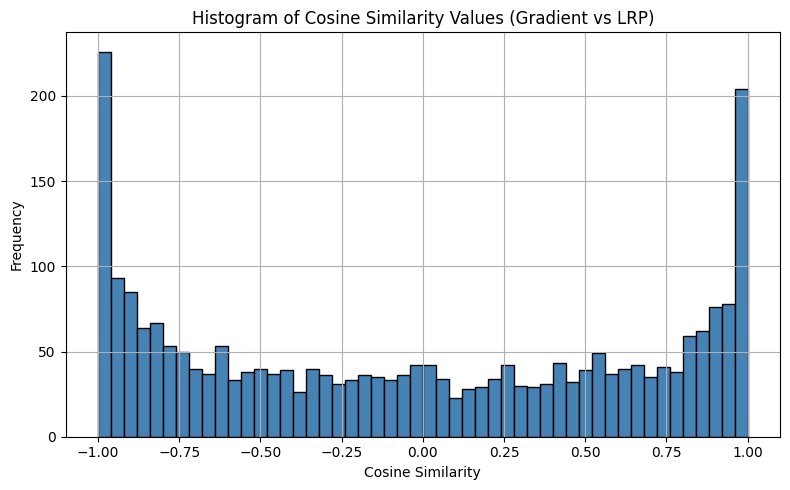

In [27]:
import matplotlib.pyplot as plt

# Flatten the 2D cosine_map into a 1D array
cosine_values = cosine_map.flatten()  # or cosine_map.ravel()

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(cosine_values, bins=50, color='steelblue', edgecolor='black')
plt.title('Histogram of Cosine Similarity Values (Gradient vs LRP)')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

[[0.90423381 0.99994153 0.07203726 ... 0.0283647  0.78856301 0.90852463]
 [0.22192721 0.38482571 0.52897716 ... 0.19626796 0.75535524 0.47474018]
 [0.62686181 0.37711185 0.93731391 ... 0.90466398 0.60244215 0.98741674]
 ...
 [0.9615652  0.19548738 0.93199939 ... 0.24484676 0.15091991 0.01578939]
 [0.84610379 0.88710076 0.80359483 ... 0.96881437 0.99994063 0.91440541]
 [0.98856872 0.34817123 0.99869269 ... 0.49019423 0.90950024 0.99074364]]


ValueError: The number of FixedLocator locations (3), usually from a call to set_ticks, does not match the number of labels (7).

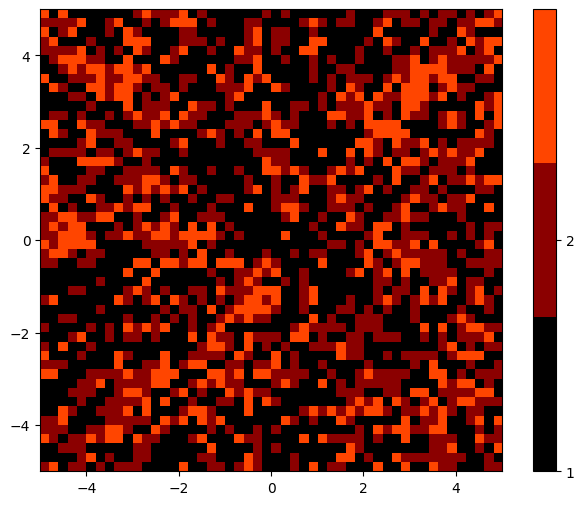

In [121]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# --- Define bucket mapping ---
def bucket_cosine_similarity(cos_val):
    """
    Buckets cosine similarity into categories:
    0: exact opposite (-1.0)
    1: strongly opposite (-0.96 to -1.0)
    2: somewhat opposite (-0.5 to -0.96)
    3: orthogonal (-0.5 to 0.5)
    4: moderately aligned (0.5 to 0.96)
    5: strongly aligned (0.96 to 1.0)
    6: exact same (1.0)
    """
    # if cos_val < 0.7:
    #     return 3
    # else:
    #     return 4
    
    if cos_val < 0.7:
        return 1  # Orthogonal (centered at 0, includes –0.5 to +0.5)
    elif cos_val < 0.96:
        return 2  # Moderately aligned
    elif cos_val < 1.0:
        return 3  # Very similar
    else:
        return 3  # Perfect alignment

# --- Apply bucketing to cosine map ---
buckets_map = np.vectorize(bucket_cosine_similarity)(cosine_map)
print(cosine_map)
# --- Custom color map ---
colors = [
    "#000000",  # 3: Orthogonal (black)
    "#8b0000",  # 1: Strongly opposite (deep red)
    "#ff4500",  # 2: Somewhat opposite (orange-red)
    

]
cmap = ListedColormap(colors)

# --- Plot categorical heatmap ---
plt.figure(figsize=(8, 6))
plt.imshow(buckets_map, origin='lower', extent=[-5, 5, -5, 5], cmap=cmap)
cbar = plt.colorbar(ticks=np.arange(len(colors)))
cbar.ax.set_yticklabels([
    'Strongly Opposite',
    'Somewhat Opposite',
    'Orthogonal',
    'Moderately Aligned',
    'Strongly Aligned',
    'Very Similar',
    'Perfect Match',
])
plt.title("Categorized Cosine Similarity: Gradient vs LRP")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(False)
plt.tight_layout()
plt.show()

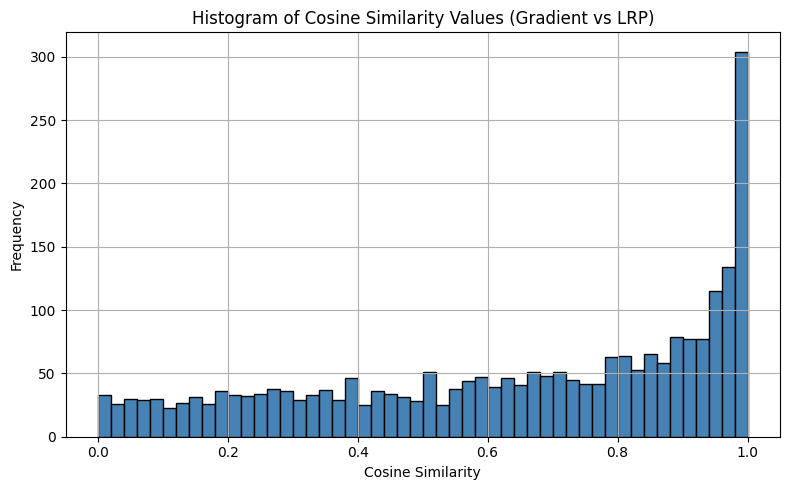

In [122]:
import matplotlib.pyplot as plt

# Flatten the 2D cosine_map into a 1D array
cosine_values = cosine_map.flatten()  # or cosine_map.ravel()

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(cosine_values, bins=50, color='steelblue', edgecolor='black')
plt.title('Histogram of Cosine Similarity Values (Gradient vs LRP)')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

In [113]:
import numpy as np
import matplotlib.pyplot as plt
import torch
def cosine_sim_np(a, b, eps=0):
    return np.abs(np.dot(a, b) 
                  #/ (np.linalg.norm(a) * np.linalg.norm(b) + eps)
                  )
# === Randomly sample 10 points from input domain ===
def sample_points(n=10, low=-1, high=1):
    return np.random.uniform(low, high, size=(n, 2))

# === Arrow plot for LRP and gradient vectors ===
def plot_vectors(model, n_points=10):
    cos_set = []
    points = sample_points(n_points)
    
    grad_vectors = []
    lrp_vectors = []

    for point in points:
        pt_tensor = torch.tensor(point, dtype=torch.float32)
        lrp = TwoDWeights_LRPModel(model)
        
        
     
        #grad = get_gradient(model, torch.tensor([X[i, j], Y[i, j]], dtype=torch.float32)).numpy()
       
        # Gradient
        grad = get_gradient(model, pt_tensor).detach().numpy()

        # LRP
       
        lrp_vec = lrp.get_FI(torch.tensor(point, dtype = torch.float32))[1][0].numpy()
        grad_vectors.append(grad*10)
        lrp_vectors.append(lrp_vec*10)
        cos_set.append(cosine_sim_np(grad, lrp_vec))
    points = np.array(points)
    grad_vectors = np.array(grad_vectors)
    lrp_vectors = np.array(lrp_vectors)
    print(grad_vectors)
    print(lrp_vectors)
    plt.figure(figsize=(8, 8))
    plt.quiver(points[:, 0], points[:, 1], grad_vectors[:, 0], grad_vectors[:, 1],
               color='blue', angles='xy', scale_units='xy', scale=1, label='Gradient')
    plt.quiver(points[:, 0], points[:, 1], lrp_vectors[:, 0], lrp_vectors[:, 1],
               color='red', angles='xy', scale_units='xy', scale=1, label='LRP')

    plt.xlim(-5, 5)
    plt.ylim(-5, 5)
    plt.gca().set_aspect('equal')
    plt.grid(True)
    plt.legend()
    plt.title('Gradient (blue) vs LRP (red) Vectors at Random Points')
    plt.xlabel('Input X')
    plt.ylabel('Input Y')
    plt.tight_layout()
    plt.show()
    print(cos_set)

[[ 0.68409455 -0.6531847 ]
 [-0.10174377  1.208254  ]
 [ 0.31866157  0.9702924 ]]
[[0.8816254  0.28949475]
 [0.12588756 0.93432933]
 [0.4989193  0.19061966]]


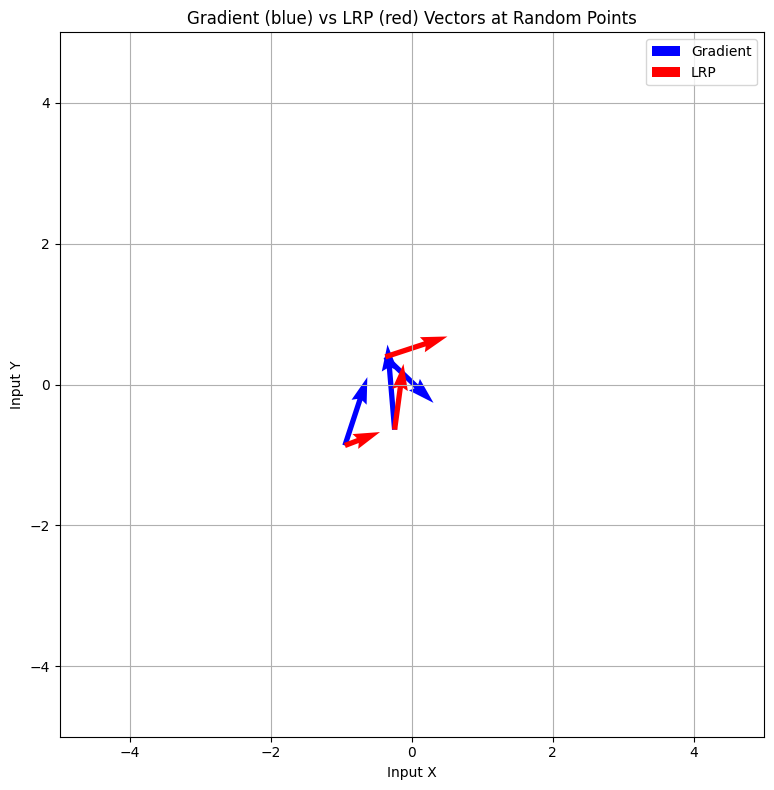

[0.0041402164, 0.011160988, 0.003439432]


In [114]:
plot_vectors(model,n_points=3)

In [113]:
def grad_cam_ish(model, )
    activations = {}
    gradients = {}
    def forward_hook(name):
        def hook(module, input, output):
            activations[name] = output.detach()
        return hook

    # Hook to capture gradients w.r.t. outputs
    def backward_hook(name):
        def hook(module, grad_input, grad_output):
            gradients[name] = grad_output[0].detach()
        return hook

    # Register hooks for each layer
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear):
            module.register_forward_hook(forward_hook(name))
            module.register_backward_hook(backward_hook(name))

    # === Sample input ===
    input_point = torch.tensor([[1.0, 1.0]], requires_grad=True)

    # Forward pass
    output = model(input_point)

    # Backward pass (ensure scalar output)
    output.backward()

    # Mean gradient for each neuron (shape: [32])
    weights = gradients['input_layer'].mean(dim=0)  # like alpha_k

    # Weighted sum of activations (shape: [1, 32])
    cam = (weights * activations['input_layer'].squeeze()).cpu().numpy()

    # Optional: ReLU to zero out negatives
    cam = np.maximum(cam, 0)

    input_contrib = cam @ model.input_layer.weight.detach().numpy()

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [107]:
# Mean gradient for each neuron (shape: [32])
weights = gradients['input_layer'].mean(dim=0)  # like alpha_k

# Weighted sum of activations (shape: [1, 32])
cam = (weights * activations['input_layer'].squeeze()).cpu().numpy()

# Optional: ReLU to zero out negatives
cam = np.maximum(cam, 0)

In [108]:
cam

array([7.0022784e-02, 4.1380640e-02, 0.0000000e+00, 0.0000000e+00,
       2.2600007e-05, 6.2268524e-04, 0.0000000e+00, 8.1466002e-05,
       3.0547261e-04, 9.8492150e-05, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 4.7426061e-03, 0.0000000e+00,
       0.0000000e+00, 4.3709278e-02, 0.0000000e+00, 0.0000000e+00,
       1.7996845e-04, 5.4028478e-02, 1.2481446e-05, 6.8072397e-03,
       1.0281018e-03, 7.6282645e-06, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 3.4719321e-04, 1.3309030e-03, 1.2614124e-02],
      dtype=float32)

In [111]:
input_contrib = cam @ model.input_layer.weight.detach().numpy()

In [112]:
input_contrib

array([0.00886752, 0.05678764], dtype=float32)